In [1]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import *

Using TensorFlow backend.


# Loading the Data Training and weather data  

In [2]:
rawtrain = pd.read_csv("D:\\PythonSamples\\NYTaxi\\train\\train.csv")

In [3]:
weatherdata = pd.read_csv("D:\\PythonSamples\\NYTaxi\\Weather_data_nyc_centralpark_2016.csv")

# Renaming column names

In [4]:
weatherdata = weatherdata.rename(columns = {'maximum temerature':'maximum_temerature'})
weatherdata = weatherdata.rename(columns = {'minimum temperature':'minimum_temperature'})
weatherdata = weatherdata.rename(columns = {'average temperature':'average_temperature'})
weatherdata = weatherdata.rename(columns = {'snow fall':'snow_fall'})
weatherdata = weatherdata.rename(columns = {'snow depth':'snow_depth'})

# Format the Date Column

In [6]:
weatherdata['date'] = weatherdata['date'].str.replace('-','/')

# Function for updating T values in the dataset with 0.01 

In [7]:
def remove_t_precip(row):
    check_t = row['precipitation']
    if check_t == 'T':
        return 0.01
    else:
        return check_t

def remove_t_sfall(row):
    check_t = row['snow_fall']
    if check_t == 'T':
        return 0.01
    else:
        return check_t

def remove_t_sdepth(row):
    check_t = row['snow_depth']
    if check_t == 'T':
        return 0.01
    else:
        return check_t

In [8]:
weatherdata['precipitation'] = weatherdata.apply(remove_t_precip, axis = 1)
weatherdata['snow_fall'] = weatherdata.apply(remove_t_sfall, axis = 1)
weatherdata['snow_depth'] = weatherdata.apply(remove_t_sdepth, axis = 1)

# Changing the datatype of the features 

In [9]:
weatherdata['precipitation'] = weatherdata['precipitation'].astype(float)
weatherdata['snow_fall'] = weatherdata['snow_fall'].astype(float)
weatherdata['snow_depth'] = weatherdata['snow_depth'].astype(float)

# Fucntions to create derived features from the Train dataset

In [10]:
#function to find the distance between Pickup and drop locations
def find_distance(row):# approximate radius of earth in km
    R = 6373.0
    lat1 = radians(abs(row['pickup_latitude']))
    lon1 = radians(abs(row['pickup_longitude']))
    lat2 = radians(abs(row['dropoff_latitude']))
    lon2 = radians(abs(row['dropoff_longitude']))
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return int(round(distance))

#function to convert flags N and y to 0 and 1 
def store_flag(row):
    flags = row['store_and_fwd_flag']
    if flags == 'N':
        return 0
    else:
        return 1
    
#function to convert pickup time to number value   
import time
import datetime

def converttime(row):
    Pickup_time = row['pickup_datetime']
    #  '2016-01-01 17:44:40'
    formated_time = time.mktime(datetime.datetime.strptime(Pickup_time, "%Y-%m-%d %H:%M:%S").timetuple())
    return formated_time

#function to find weekdays and weekends 0 denotes weekends and 1 denotes weekdays 
def find_weekday(row):
    pickuptime = row['pickup_datetime']
    weekdays = datetime.datetime.strptime(pickuptime, "%Y-%m-%d %H:%M:%S").weekday()
    if weekdays >= 5:
        return 0
    else:
        return 1

#function to mark peak hours of the day 
def find_peakhour(row):
    pickuptime = row['pickup_datetime']
    hourofday = datetime.datetime.strptime(pickuptime, "%Y-%m-%d %H:%M:%S").hour
    peakhours = [6,7,8,9,16,17,18,19,20]
    if hourofday in peakhours:
        return 1
    else:
        return 0

#function to mark working hours of the day
def find_work_hour(row):
    pickuptime = row['pickup_datetime']
    hourofday = datetime.datetime.strptime(pickuptime, "%Y-%m-%d %H:%M:%S").hour
    peakhours = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    if hourofday in peakhours:
        return 1
    else:
        return 0
    
#function to extract only the hour of the trip
def find_hour(row):
    pickuptime = row['pickup_datetime']
    hourofday = datetime.datetime.strptime(pickuptime, "%Y-%m-%d %H:%M:%S").hour
    return hourofday

#function to extract the format the date of the trip
def pickup_day(row):
    pick_day = row['pickup_datetime']
    yer = datetime.datetime.strptime(pick_day, "%Y-%m-%d %H:%M:%S").year
    mont = datetime.datetime.strptime(pick_day, "%Y-%m-%d %H:%M:%S").month
    dy = datetime.datetime.strptime(pick_day, "%Y-%m-%d %H:%M:%S").day
    return str(dy)+"/"+str(mont)+"/"+str(yer)

#function to convert trip duration in seconds to minutes
def conv_mints(row):
    triptime = row['trip_duration']
    tripdura = triptime/60
    return tripdura

#function to calculate the speed of the trip
def cal_speed(row):
    dist = row['distance']
    time = row['trip_duration']
    dist_meter = dist*1000
    return dist_meter/time

#function to mark the trip duration more that a day
def trip_duration_day(row):
    time = row['trip_dura_mins']
    if (time/60) > 24 :
        return 1
    else:
        return 0

# Applying the functions to the train dataset

In [11]:
rawtrain['pickup_day'] = rawtrain.apply(pickup_day,axis = 1)

In [12]:
rawtrain['distance'] = rawtrain.apply(find_distance,axis = 1)

In [13]:
rawtrain['weekday_end'] = rawtrain.apply(find_weekday,axis = 1)

In [14]:
rawtrain['peak_hour'] = rawtrain.apply(find_peakhour,axis = 1)

In [15]:
rawtrain['pickup_time'] = rawtrain.apply(converttime,axis = 1)

In [16]:
rawtrain['pickup_hour'] =  rawtrain.apply(find_hour, axis = 1)

In [17]:
rawtrain['store_fwd_flag'] = rawtrain.apply(store_flag,axis = 1)

In [18]:
rawtrain['trip_dura_mins'] = rawtrain.apply(conv_mints,axis = 1)

In [19]:
rawtrain['speed'] = rawtrain.apply(cal_speed, axis =1)

In [20]:
rawtrain['working_hour'] = rawtrain.apply(find_work_hour, axis =1)

In [21]:
rawtrain['over_day'] = rawtrain.apply(trip_duration_day,axis = 1)

In [22]:
rawtrain = rawtrain.rename(columns = {'pickup_day':'date'})

In [24]:
full_traindata =rawtrain[['id','vendor_id','pickup_time','passenger_count','pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude','date','distance', 'weekday_end', 'peak_hour','pickup_hour','speed','store_fwd_flag','working_hour','over_day','trip_dura_mins']]

# Visualize the data for outliers 

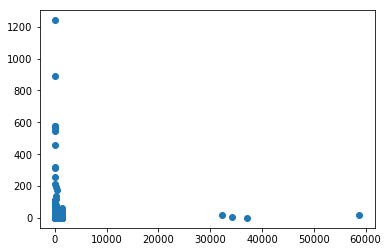

In [25]:
plt.scatter(full_traindata['trip_dura_mins'],full_traindata['distance'])

# Remove the outliers

In [26]:
wout_train_data = full_traindata.loc[full_traindata['trip_dura_mins'] <= 1500]
len(wout_train_data)

1458640

In [27]:
wout_train_data = wout_train_data.loc[wout_train_data['distance'] <= 200]
len(wout_train_data)

1458629

In [ ]:
#wout_train_data = wout_train_data.loc[wout_train_data['distance'] != 0.000000]
#len(wout_train_data)

In [28]:
wout_train_data = wout_train_data.loc[wout_train_data['trip_dura_mins'] > 1.000000]
len(wout_train_data)

1449852

# Visuvalize the partial results of outlier removal

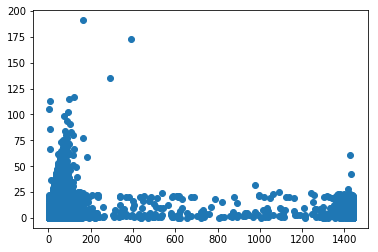

In [29]:
plt.scatter(wout_train_data['trip_dura_mins'],wout_train_data['distance'])

In [ ]:
#outlier1 = wout_train_data.loc[(wout_train_data['trip_dura_mins'] > 2) & (wout_train_data['distance'] <= 1)]

In [ ]:
#outlier2 = wout_train_data.loc[(wout_train_data['trip_dura_mins'] > 200) & (wout_train_data['distance'] < 20)]

In [30]:
outlier3 = wout_train_data.loc[(wout_train_data['trip_dura_mins'] <=  10) & (wout_train_data['distance'] > 20)]

In [ ]:
#outlier4 = wout_train_data.loc[wout_train_data['trip_dura_mins'] <= 2]

In [ ]:
#wout_train_data = wout_train_data[~wout_train_data.isin(outlier1.to_dict('l')).all(1)]

In [ ]:
#wout_train_data = wout_train_data[~wout_train_data.isin(outlier2.to_dict('l')).all(1)]

In [31]:
wout_train_data = wout_train_data[~wout_train_data.isin(outlier3.to_dict('l')).all(1)]

In [ ]:
#wout_train_data = wout_train_data[~wout_train_data.isin(outlier4.to_dict('l')).all(1)]

# Remove trips more than a day

In [32]:
wout_train_data = wout_train_data.loc[wout_train_data['over_day'] == 0]
len(wout_train_data)

1449847

# Average speed per distance level 

In [33]:
speed_dist_mean = pd.DataFrame(pd.DataFrame(wout_train_data[['distance','speed']]).groupby('distance').mean())

In [34]:
speed_dist_mean = speed_dist_mean.reset_index()

In [35]:
speed_dist_mean = speed_dist_mean.rename(columns = {'speed':'mean_speed'})

In [36]:
speed_dist_mean['total_speed'] = speed_dist_mean['distance']*(speed_dist_mean['mean_speed']*1000)

# Average speed per Hour

In [37]:
speed_dist_hr = pd.DataFrame(pd.DataFrame(wout_train_data[['pickup_hour','speed']]).groupby('pickup_hour').mean())

In [38]:
speed_dist_hr = speed_dist_hr.reset_index()

In [39]:
speed_dist_hr = speed_dist_hr.rename(columns = {'speed':'speed_hr'})

# Adding speed feature to the dataset

In [40]:
wout_train_data = pd.DataFrame.merge(wout_train_data, speed_dist_mean,  how='left', on='distance')

In [41]:
wout_train_data = pd.DataFrame.merge(wout_train_data, speed_dist_hr,  how='left', on='pickup_hour')

# Adding weather features to the dataset

In [42]:
wout_train_data = pd.DataFrame.merge(wout_train_data, weatherdata, on='date')

In [43]:
len(wout_train_data)

1449847

# Final features of the Train dataset 

In [44]:
final_traindata = wout_train_data[['vendor_id','pickup_time','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','speed_hr','weekday_end','peak_hour','pickup_hour','store_fwd_flag','working_hour','total_speed','maximum_temerature', 'minimum_temperature', 'average_temperature','precipitation', 'snow_fall', 'snow_depth','trip_dura_mins']]

# Training Split

In [45]:
sample_traindata = final_traindata.head(1349847)

In [46]:
len(sample_traindata.columns)

22

In [47]:
net_traindata = sample_traindata 

# Scaling the Dataset to use it in Tensorflow deep learning module

In [48]:
scaler = MinMaxScaler(feature_range=(0,1))

In [49]:
msk = np.random.rand(len(net_traindata)) < 0.8

Xtrain = net_traindata[msk]

Xtest = net_traindata[~msk]

In [50]:
scaled_data = scaler.fit_transform(Xtrain)
scaled_test = scaler.transform(Xtest)

# Get the scaled value of the target feature for using it again for upscaling

In [51]:
print("multiplying by {:.10f} and adding {:.6f}".format(scaler.scale_[21],scaler.min_[21]))

multiplying by 0.0006949995 and adding -0.000707


# Split The Dependent and Independent features 

In [52]:
X_rush_ind = np.array(pd.DataFrame(scaled_data).iloc[:,0:21])
Y_rush_dep = np.array(pd.DataFrame(scaled_data).iloc[:,21])

# Define the Deep learning neural net model

In [53]:
model = Sequential()
model.add(Dense(50, input_dim=21, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss="mean_squared_error", optimizer="adam")

# Run the model with training Data

In [54]:
model.fit(X_rush_ind,Y_rush_dep,epochs=50,shuffle=True,verbose=2)

Epoch 1/50
48s - loss: 0.0013
Epoch 2/50
47s - loss: 0.0013
Epoch 3/50
47s - loss: 0.0013
Epoch 4/50
47s - loss: 0.0013
Epoch 5/50
47s - loss: 0.0013
Epoch 6/50
47s - loss: 0.0013
Epoch 7/50
47s - loss: 0.0013
Epoch 8/50
47s - loss: 0.0013
Epoch 9/50
47s - loss: 0.0013
Epoch 10/50
47s - loss: 0.0013
Epoch 11/50
47s - loss: 0.0013
Epoch 12/50
47s - loss: 0.0013
Epoch 13/50
47s - loss: 0.0013
Epoch 14/50
47s - loss: 0.0013
Epoch 15/50
46s - loss: 0.0013
Epoch 16/50
47s - loss: 0.0013
Epoch 17/50
47s - loss: 0.0013
Epoch 18/50
46s - loss: 0.0013
Epoch 19/50
47s - loss: 0.0013
Epoch 20/50
47s - loss: 0.0013
Epoch 21/50
47s - loss: 0.0013
Epoch 22/50
47s - loss: 0.0013
Epoch 23/50
47s - loss: 0.0013
Epoch 24/50
46s - loss: 0.0013
Epoch 25/50
47s - loss: 0.0013
Epoch 26/50
47s - loss: 0.0013
Epoch 27/50
47s - loss: 0.0013
Epoch 28/50
47s - loss: 0.0013
Epoch 29/50
47s - loss: 0.0013
Epoch 30/50
46s - loss: 0.0013
Epoch 31/50
47s - loss: 0.0013
Epoch 32/50
47s - loss: 0.0013
Epoch 33/50
46s -

# Test the model Accuracy

In [55]:
X_rush_ind_t = np.array(pd.DataFrame(scaled_test).iloc[:,0:21])
Y_rush_dep_t = np.array(pd.DataFrame(scaled_test).iloc[:,21])

In [56]:
test_error_rate = model.evaluate(X_rush_ind_t, Y_rush_dep_t, verbose=0)
print("the MSE for the test is: {} ".format(test_error_rate))

the MSE for the test is: 0.001251170786869547 


# Test the model with new data

In [57]:
non_traindata = wout_train_data.tail(100000)

In [60]:
test_weekdayrushhr = non_traindata[['vendor_id','pickup_time','passenger_count','pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude','distance','speed_hr','weekday_end', 'peak_hour','pickup_hour','store_fwd_flag','working_hour','total_speed','maximum_temerature', 'minimum_temperature', 'average_temperature','precipitation', 'snow_fall', 'snow_depth','trip_dura_mins']]

In [61]:
len(test_weekdayrushhr.columns)

22

# Scale the Test data with training scale

In [62]:
scaled_data_test = scaler.transform(test_weekdayrushhr)

# Split The Dependent and Independent features 

In [63]:
X_rush_ind_te=np.array(pd.DataFrame(scaled_data_test).iloc[:,0:21])
Y_rush_dep_te=np.array(pd.DataFrame(scaled_data_test).iloc[:,21])

In [64]:
#Only the Independent set is used as we have to predict he dependent using our model 
Xnewtest = X_rush_ind_te

# Run prediction

In [65]:
prediction = model.predict(Xnewtest)

# UpScale the data to actula value

In [66]:
prediction_upscale = prediction+0.000707
prediction_upscale = prediction_upscale/0.0006949995
len(prediction_upscale)
#Y_rush_dep_te

100000

In [67]:
Y_rush_dep_te_Act = Y_rush_dep_te+0.000707
Y_rush_dep_te_Act = Y_rush_dep_te_Act/0.0006949995
len(Y_rush_dep_te_Act)

100000

# Convert minutes to seconds

In [68]:
pred = pd.DataFrame(prediction_upscale*60)
actu = pd.DataFrame(Y_rush_dep_te_Act*60)

# Table the Predicted and Actual to see the difference

In [87]:
merged = pd.merge(left=pred.round().astype(int), left_index=True,
                  right=actu.round().astype(int), right_index=True,
                  how='inner')

In [88]:
merged

,0_x,0_y
0,1224,1317
1,1777,2120
2,258,304
3,404,515
4,258,259
5,258,318
6,345,377
7,465,348
8,465,447
9,258,405


# Visuvalize the Predicted vs Actual using a Graph

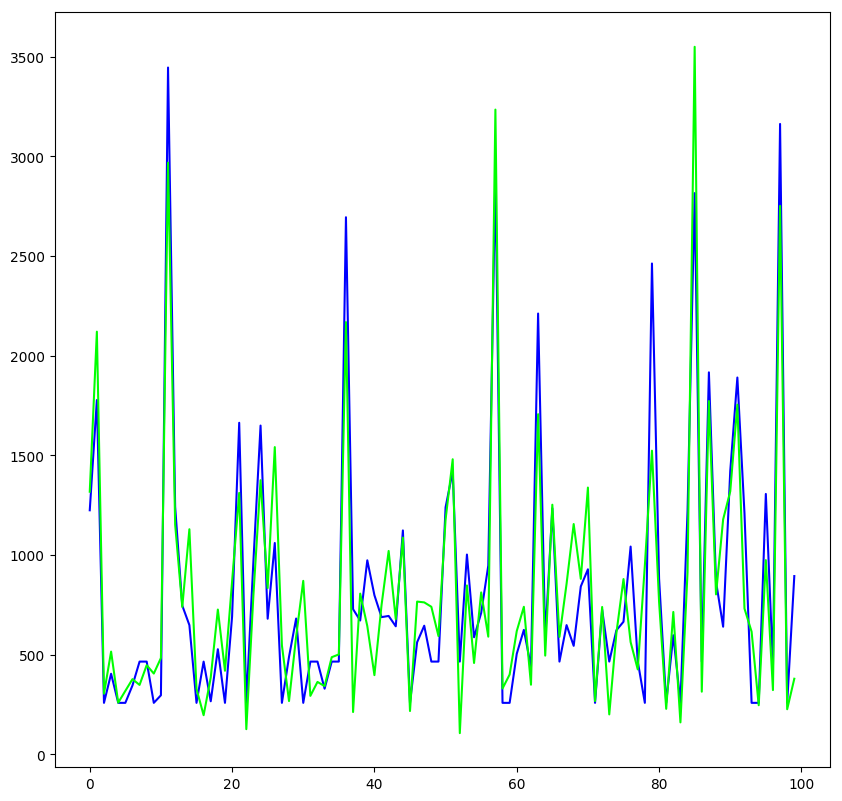

In [72]:
my_dpi=99
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
plt.plot(merged['0_x'].head(100),color='blue') #Predicted
plt.plot(merged['0_y'].head(100),color='lime') #Actual

# Find the Root Mean Squared Log Error(RMSLE)

In [73]:
#function to find rmsle
def rmsle(predicted,real):
    sum=0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

In [89]:
rmsle(merged['0_x'],merged['0_y'])

0.52954660734171166

# Load the test data of the competion 

In [75]:
rawtest = pd.read_csv("D:\\PythonSamples\\NYTaxi\\test\\test.csv")

In [76]:
len(rawtest)

625134

# Applying the functions on test dataset to get the derived columns

In [77]:
rawtest['pickup_day'] = rawtest.apply(pickup_day,axis = 1)

In [78]:
rawtest['distance'] = rawtest.apply(find_distance,axis = 1)

In [79]:
rawtest['weekday_end'] = rawtest.apply(find_weekday,axis = 1)

In [80]:
rawtest['peak_hour'] = rawtest.apply(find_peakhour,axis = 1)

In [81]:
rawtest['pickup_time'] = rawtest.apply(converttime,axis = 1)

In [82]:
rawtest['pickup_hour'] =  rawtest.apply(find_hour, axis = 1)

In [83]:
rawtest['store_fwd_flag'] = rawtest.apply(store_flag,axis = 1)

In [84]:
rawtest['working_hour'] = rawtest.apply(find_work_hour, axis =1)

In [85]:
rawtest = rawtest.rename(columns = {'pickup_day':'date'})

In [100]:
wout_test_data = rawtest

# Applying speed Calculations

In [101]:
wout_test_data = pd.DataFrame.merge(wout_test_data, speed_dist_mean,  how='left', on='distance')

In [102]:
wout_test_data = pd.DataFrame.merge(wout_test_data, speed_dist_hr,  how='left', on='pickup_hour')

# Applying weather features

In [103]:
wout_test_data = pd.DataFrame.merge(wout_test_data, weatherdata, on='date')

In [104]:
wout_test_data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'date', 'distance',
       'weekday_end', 'peak_hour', 'pickup_time', 'pickup_hour',
       'store_fwd_flag', 'working_hour', 'mean_speed', 'total_speed',
       'speed_hr', 'maximum_temerature', 'minimum_temperature',
       'average_temperature', 'precipitation', 'snow_fall', 'snow_depth'],
      dtype='object')

# Final test data

In [105]:
#'speed_hr'
final_test_data = wout_test_data[['vendor_id','pickup_time','passenger_count','pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude','distance','speed_hr','weekday_end', 'peak_hour','pickup_hour','store_fwd_flag','working_hour','total_speed','maximum_temerature', 'minimum_temperature', 'average_temperature','precipitation', 'snow_fall', 'snow_depth']]

# Create Dummy feature

In [106]:
final_test_data['duraction'] = 0.1

C:\Users\hdadmin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [107]:
len(final_test_data.columns)

22

In [108]:
final_test_data['total_speed'].fillna(0, inplace=True)

C:\Users\hdadmin\Anaconda3\lib\site-packages\pandas\core\generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [113]:
Xnew_test = final_test_data

# Scale the data with scaler

In [114]:
scaled_test_data = scaler.transform(Xnew_test)

# Delete the dummy feature

In [115]:
scaled_test_data = np.delete(scaled_test_data, [21], axis=1)

# Run the Predection

In [116]:
prediction_newset = model.predict(scaled_test_data)

# Upscale the Prediction

In [117]:
prediction_upscale_new = prediction_newset+0.000707
prediction_upscale_new = prediction_upscale_new/0.0006949995
prediction_upscale_new = prediction_upscale_new*60

# convert the array to a data frame

In [118]:
pred_new = pd.DataFrame(prediction_upscale_new, columns = ['trip_duration'])

In [119]:
pred_new.round().astype(int).head(200)

,trip_duration
0,465
1,465
2,258
3,1209
4,258
5,673
6,674
7,465
8,2329
9,559


# Final test dataset with tripduration

In [123]:
merged_final = pd.merge(left=rawtest, left_index=True,
                  right=pred_new, right_index=True,
                  how='inner')

In [124]:
#merged_final = merged_final.rename(columns = {'0':'trip_duration'})

In [125]:
merged_final[['id','trip_duration']].to_csv("D:\\PythonSamples\\NYTaxi\\sample_submission.csv", index=False)

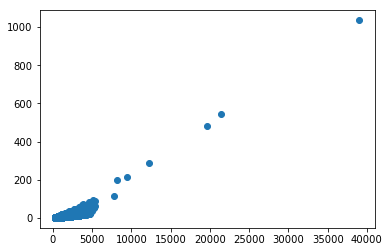

In [126]:
plt.scatter(merged_final['trip_duration'],merged_final['distance'])